In [1]:
import pytraj as pt
import mdtraj as md
import numpy as np
from openbabel import pybel
from tempfile import NamedTemporaryFile

# simple pdb file

In [10]:
traj = pt.load("/data/backup/cicada/cbouysset/workspace/bitter/old.models_t2r/ali/T2R16_HUMAN/5JQH/T2R16_HUMAN.B99990048.pdb")
traj

pytraj.Trajectory, 1 frames: 
Size: 0.000054 (GB)
<Topology: 2397 atoms, 291 residues, 1 mols, non-PBC>
           

In [11]:
for atom in traj.topology.atoms:
    if atom.charge != 0:
        print(atom)

In [12]:
r = traj.topology.residue(8)
print(r)
for atom in [a for a in traj.topology.atoms][r.first_atom_index:r.last_atom_index]:
    print(atom)

<PHE8, 11 atoms>
Atom(name=N, type=, atomic_number=7, index=62, resid=8)
Atom(name=CA, type=, atomic_number=6, index=63, resid=8)
Atom(name=CB, type=, atomic_number=6, index=64, resid=8)
Atom(name=CG, type=, atomic_number=6, index=65, resid=8)
Atom(name=CD1, type=, atomic_number=6, index=66, resid=8)
Atom(name=CD2, type=, atomic_number=6, index=67, resid=8)
Atom(name=CE1, type=, atomic_number=6, index=68, resid=8)
Atom(name=CE2, type=, atomic_number=6, index=69, resid=8)
Atom(name=CZ, type=, atomic_number=6, index=70, resid=8)
Atom(name=C, type=, atomic_number=6, index=71, resid=8)
Atom(name=O, type=, atomic_number=8, index=72, resid=8)


PDB: no atom types, no charges, might be missing hydrogens

# rec and docking pose from vina

In [233]:
rec = pt.load("/data/backup/cicada/cbouysset/workspace/bitter/t2r16/docking/receptors/5JQH/T2R16_HUMAN.B99990041.pdbqt")
rec

pytraj.Trajectory, 1 frames: 
Size: 0.000065 (GB)
<Topology: 2892 atoms, 291 residues, 1 mols, non-PBC>
           

In [234]:
for atom in rec.topology.atoms:
    if atom.charge != 0:
        print(atom)

In [235]:
r = rec.topology.residue(8)
print(r)
for atom in [a for a in rec.topology.atoms][r.first_atom_index:r.last_atom_index]:
    print(atom)

<PHE8, 12 atoms>
Atom(name=N, type=, atomic_number=7, index=74, resid=8)
Atom(name=HN, type=, atomic_number=1, index=75, resid=8)
Atom(name=CA, type=, atomic_number=6, index=76, resid=8)
Atom(name=C, type=, atomic_number=6, index=77, resid=8)
Atom(name=O, type=, atomic_number=8, index=78, resid=8)
Atom(name=CB, type=, atomic_number=6, index=79, resid=8)
Atom()
Atom()
Atom()
Atom()
Atom()
Atom()


PDBQT: cannot be read directly by pytraj (read as a bad PDB). But since Vina is used a lot, we should find a workaround !

In [128]:
lig = pt.load("/data/backup/cicada/cbouysset/workspace/bitter/t2r16/docking/output/5JQH/T2R16_HUMAN.B99990041/ligand_001/docking_poses.pdbqt")
lig

pytraj.Trajectory, 216 frames: 
Size: 0.000005 (GB)
<Topology: 1 atoms, 1 residues, 1 mols, non-PBC>
           

In [34]:
lig = pt.load("/data/backup/cicada/cbouysset/workspace/bitter/t2r16/docking/output/5JQH/T2R16_HUMAN.B99990041/ligand_001/docking_poses.pdbqt")
lig

pytraj.Trajectory, 216 frames: 
Size: 0.000005 (GB)
<Topology: 1 atoms, 1 residues, 1 mols, non-PBC>
           

9


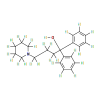

In [146]:
ligs = [i for i in pybel.readfile("pdbqt", "/data/backup/cicada/cbouysset/workspace/bitter/t2r16/docking/output/5JQH/T2R16_HUMAN.B99990041/ligand_001/docking_poses.pdbqt")]
print(len(ligs))
lig = ligs[0]
# necessary to properly add H
lig = pybel.readstring("pdb", lig.write("pdb"))
lig.addh()
lig

In [2]:
def pdbqt_to_mol2(path):
    mols = []
    for m in pybel.readfile("pdbqt", path):
        # necessary to properly add H
        mH = pybel.readstring("pdb", m.write("pdb"))
        mH.addh()
        # need to reassign old charges to mol
        mH.OBMol.SetPartialChargesPerceived(True)
        for i, (atom, old) in enumerate(zip(mH.atoms, m.atoms)):
            if i == len(m.atoms): # stop at new hydrogens
                break
            # assign old charges
            atom.OBAtom.SetPartialCharge(old.partialcharge)
        mols.append(mH)
    return "\n".join(x.write("mol2") for x in mols)

with NamedTemporaryFile(mode='w', encoding='utf-8') as f:
    data = pdbqt_to_mol2("/data/backup/cicada/cbouysset/workspace/bitter/t2r16/docking/output/5JQH/T2R16_HUMAN.B99990041/ligand_001/docking_poses.pdbqt")
    f.write(data)
    traj = pt.load(f.name)

traj

pytraj.Trajectory, 9 frames: 
Size: 0.000010 (GB)
<Topology: 50 atoms, 1 residues, 1 mols, non-PBC>
           

In [195]:
for atom in traj.topology.atoms:
        print(atom, atom.charge)

Atom(name=C1, type=C.3, atomic_number=6, index=0, resid=0) 0.112
Atom(name=O1, type=O.3, atomic_number=8, index=1, resid=0) -0.38
Atom(name=H1, type=H, atomic_number=1, index=2, resid=0) 0.211
Atom(name=C2, type=C.3, atomic_number=6, index=3, resid=0) 0.05
Atom(name=C3, type=C.3, atomic_number=6, index=4, resid=0) 0.034
Atom(name=C4, type=C.3, atomic_number=6, index=5, resid=0) 0.272
Atom(name=N1, type=N.3, atomic_number=7, index=6, resid=0) 0.088
Atom(name=C5, type=C.3, atomic_number=6, index=7, resid=0) 0.272
Atom(name=C6, type=C.3, atomic_number=6, index=8, resid=0) 0.03
Atom(name=C7, type=C.3, atomic_number=6, index=9, resid=0) 0.003
Atom(name=C8, type=C.3, atomic_number=6, index=10, resid=0) 0.03
Atom(name=C9, type=C.3, atomic_number=6, index=11, resid=0) 0.272
Atom(name=C10, type=C.ar, atomic_number=6, index=12, resid=0) -0.019
Atom(name=C11, type=C.ar, atomic_number=6, index=13, resid=0) 0.01
Atom(name=C12, type=C.ar, atomic_number=6, index=14, resid=0) 0.001
Atom(name=C13, type

Now, PDBQT have atom types, partial charges, and can be read directly from Vina results (no need to split the output file). Each docking pose is read a a trajectory frame.

Other free docking software (PLANTS... and probably others) output a MOL2 file (either 1 per pose or a multi-pose single file) so we can now use docking output to read trajectories.

Aromaticity seem to be perceived correctly through the SYBYL atom types, so we should require only PDBQT or MOL2 files as input (and MD traj of course).

# rec and docking pose from PLANTS

In [237]:
rec = pt.load("/home/cbouy/Downloads/CB7-initial.mol2")
rec

pytraj.Trajectory, 1 frames: 
Size: 0.000003 (GB)
<Topology: 126 atoms, 1 residues, 1 mols, non-PBC>
           

In [239]:
for r in rec.topology.residues:
    print(r)

<CB710, 126 atoms>


In [240]:
for atom in rec.topology.atoms:
    if atom.charge != 0:
        print(atom, atom.charge)

Atom(name=O1, type=O.2, atomic_number=8, index=0, resid=0) -0.2522
Atom(name=O2, type=O.2, atomic_number=8, index=1, resid=0) -0.2522
Atom(name=O3, type=O.2, atomic_number=8, index=2, resid=0) -0.2522
Atom(name=O4, type=O.2, atomic_number=8, index=3, resid=0) -0.2522
Atom(name=O5, type=O.2, atomic_number=8, index=4, resid=0) -0.2522
Atom(name=O6, type=O.2, atomic_number=8, index=5, resid=0) -0.2522
Atom(name=O7, type=O.2, atomic_number=8, index=6, resid=0) -0.2522
Atom(name=O8, type=O.2, atomic_number=8, index=7, resid=0) -0.2522
Atom(name=O9, type=O.2, atomic_number=8, index=8, resid=0) -0.2522
Atom(name=O10, type=O.2, atomic_number=8, index=9, resid=0) -0.2522
Atom(name=O11, type=O.2, atomic_number=8, index=10, resid=0) -0.2522
Atom(name=O12, type=O.2, atomic_number=8, index=11, resid=0) -0.2522
Atom(name=O13, type=O.2, atomic_number=8, index=12, resid=0) -0.2522
Atom(name=O14, type=O.2, atomic_number=8, index=13, resid=0) -0.2522
Atom(name=N15, type=N.am, atomic_number=7, index=14, 

it's a host-guest system so there are no residues but atom types seem correct

In [241]:
lig = pt.load("/home/cbouy/Downloads/AD0_entry_00001_conf_10.mol2")
lig

pytraj.Trajectory, 1 frames: 
Size: 0.000001 (GB)
<Topology: 27 atoms, 1 residues, 1 mols, non-PBC>
           

In [242]:
for atom in lig.topology.atoms:
    print(atom, atom.charge)

Atom(name=C1, type=C.3, atomic_number=6, index=0, resid=0) -0.0379
Atom(name=C2, type=C.3, atomic_number=6, index=1, resid=0) -0.0472
Atom(name=C3, type=C.3, atomic_number=6, index=2, resid=0) -0.0379
Atom(name=C4, type=C.3, atomic_number=6, index=3, resid=0) -0.0472
Atom(name=C5, type=C.3, atomic_number=6, index=4, resid=0) -0.0472
Atom(name=C6, type=C.3, atomic_number=6, index=5, resid=0) -0.0379
Atom(name=C7, type=C.3, atomic_number=6, index=6, resid=0) -0.0211
Atom(name=C8, type=C.3, atomic_number=6, index=7, resid=0) -0.0211
Atom(name=C9, type=C.3, atomic_number=6, index=8, resid=0) -0.0211
Atom(name=C10, type=C.3, atomic_number=6, index=9, resid=0) 0.0669
Atom(name=O11, type=O.3, atomic_number=8, index=10, resid=0) -0.3885
Atom(name=H12, type=H, atomic_number=1, index=11, resid=0) 0.0302
Atom(name=H13, type=H, atomic_number=1, index=12, resid=0) 0.0271
Atom(name=H14, type=H, atomic_number=1, index=13, resid=0) 0.0271
Atom(name=H15, type=H, atomic_number=1, index=14, resid=0) 0.03

PLANTS docking output seem to be correct as well

In [243]:
lig = pt.load("/home/cbouy/Downloads/SMM2_CK571_MD.mol2")
lig

pytraj.Trajectory, 1 frames: 
Size: 0.000001 (GB)
<Topology: 61 atoms, 1 residues, 1 mols, non-PBC>
           

In [244]:
for atom in lig.topology.atoms:
    print(atom, atom.charge)

Atom(name=N1, type=n, atomic_number=7, index=0, resid=0) -0.5239
Atom(name=N2, type=n, atomic_number=7, index=1, resid=0) -0.4668
Atom(name=N3, type=n, atomic_number=7, index=2, resid=0) -0.5244
Atom(name=N4, type=nb, atomic_number=7, index=3, resid=0) -0.659
Atom(name=C5, type=ca, atomic_number=6, index=4, resid=0) 0.1289
Atom(name=C6, type=ca, atomic_number=6, index=5, resid=0) -0.0196
Atom(name=C7, type=ca, atomic_number=6, index=6, resid=0) -0.154
Atom(name=C8, type=ca, atomic_number=6, index=7, resid=0) -0.106
Atom(name=C9, type=ca, atomic_number=6, index=8, resid=0) -0.111
Atom(name=C10, type=ca, atomic_number=6, index=9, resid=0) -0.0993
Atom(name=C11, type=c3, atomic_number=6, index=10, resid=0) 0.1203
Atom(name=C12, type=c, atomic_number=6, index=11, resid=0) 0.7581
Atom(name=C13, type=c3, atomic_number=6, index=12, resid=0) 0.0753
Atom(name=C14, type=c3, atomic_number=6, index=13, resid=0) 0.0727
Atom(name=C15, type=c3, atomic_number=6, index=14, resid=0) -0.1314
Atom(name=C1

Don't remember how this was generated but aromaticity is a bit different on this one...

# md

In [188]:
traj = pt.load("/home/cbouy/Downloads/polyAT_wat_md1.nc", "/home/cbouy/Downloads/polyAT_wat.prmtop")
traj

pytraj.Trajectory, 100 frames: 
Size: 0.021878 (GB)
<Topology: 9788 atoms, 3082 residues, 3064 mols, PBC with box type = truncoct>
           

In [189]:
for atom in traj.topology.atoms:
    if abs(atom.charge) >= 1:
        print(atom)

Atom(name=P, type=P, atomic_number=15, index=30, resid=1)
Atom(name=P, type=P, atomic_number=15, index=62, resid=2)
Atom(name=P, type=P, atomic_number=15, index=94, resid=3)
Atom(name=P, type=P, atomic_number=15, index=126, resid=4)
Atom(name=P, type=P, atomic_number=15, index=158, resid=5)
Atom(name=P, type=P, atomic_number=15, index=190, resid=6)
Atom(name=P, type=P, atomic_number=15, index=222, resid=7)
Atom(name=P, type=P, atomic_number=15, index=254, resid=8)
Atom(name=P, type=P, atomic_number=15, index=286, resid=9)
Atom(name=P, type=P, atomic_number=15, index=349, resid=11)
Atom(name=P, type=P, atomic_number=15, index=381, resid=12)
Atom(name=P, type=P, atomic_number=15, index=413, resid=13)
Atom(name=P, type=P, atomic_number=15, index=445, resid=14)
Atom(name=P, type=P, atomic_number=15, index=477, resid=15)
Atom(name=P, type=P, atomic_number=15, index=509, resid=16)
Atom(name=P, type=P, atomic_number=15, index=541, resid=17)
Atom(name=P, type=P, atomic_number=15, index=573, re

In [190]:
a = traj.topology.atom(62)
a

Atom(name=P, type=P, atomic_number=15, index=0, resid=2)

In [191]:
tr = traj[':{}'.format(",".join(str(atom.resid) for atom in traj.topology.atoms if (abs(atom.charge) >= 1)))]
tr

pytraj.Trajectory, 100 frames: 
Size: 0.001390 (GB)
<Topology: 622 atoms, 36 residues, 19 mols, PBC with box type = truncoct>
           

In [192]:
for a1 in tr.topology.atoms:
    for a2 in tr.topology.atoms:
        if (a1.charge >= 1) and (a2.charge >= 1):
            i1, i2 = a1.index, a2.index
            if i1 == i2: continue
            for frame in tr[f'@{i1},{i2}']:
                distance = np.sqrt(np.sum([(x-y)**2 for x,y in zip(*frame.coordinates)]))
                if distance <= 4.0:
                    print(f"{a1.name} (charged {a1.charge}) and {a2.name} (charged {a2.charge}) were distant from {distance:.2f}A at {frame.time}ps")

P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.80A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.58A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.61A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.95A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.96A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.87A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.62A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.49A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.36A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distan

P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.07A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.70A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.76A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.58A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.54A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.72A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.52A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.81A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 2.40A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distan

P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.98A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.85A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.88A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.91A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.91A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.99A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.55A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.80A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.82A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.

P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.88A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.92A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.98A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.96A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.89A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.92A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.98A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.90A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.97A at 1.2286355632555e-311ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.

P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.83A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.84A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.75A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.96A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.97A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.89A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.80A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.64A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distant from 3.51A at 4.66854965792987e-310ps
P (charged 1.1659000016463343) and Na+ (charged 1.0) were distan

Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.91A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.80A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.99A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 4.00A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.94A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.89A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.81A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.40A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.50A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.

Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.83A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.84A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.75A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.96A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.97A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.89A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.80A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.64A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.51A at 1.2286355632555e-311ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.

Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.88A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.92A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.98A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.96A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.89A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.92A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.98A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.90A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.97A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distan

Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.95A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.85A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.45A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.99A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.94A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.75A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 4.00A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.99A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distant from 3.93A at 4.66854965792987e-310ps
Na+ (charged 1.0) and P (charged 1.1659000016463343) were distan

Most interactions are trivial to detect, except HBond donor (detect when O or N are bonded with a H) but should be easy, and aromatic interactions (the atom type highly depends on the force-field). It would be easier to convert every ligand or residue to an RDKit molecule and keep the current implementation (SMART queries).

# converting pytraj frame to RDKit mol

In [241]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
ptable = Chem.GetPeriodicTable()

In [4]:
with NamedTemporaryFile(mode='w', encoding='utf-8') as f:
    mol2_block = pdbqt_to_mol2("/data/backup/cicada/cbouysset/workspace/bitter/t2r16/docking/output/5JQH/T2R16_HUMAN.B99990041/ligand_001/docking_poses.pdbqt")
    f.write(mol2_block)
    traj = pt.load(f.name)

traj

pytraj.Trajectory, 9 frames: 
Size: 0.000010 (GB)
<Topology: 50 atoms, 1 residues, 1 mols, non-PBC>
           

In [5]:
for frame in traj:
    pass

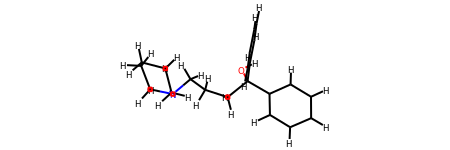

In [6]:
# for a ligand

mol = Chem.RWMol()
conf = Chem.Conformer(traj.topology.n_atoms)
for atom in traj.topology.atoms:
    # create atom
    a = Chem.Atom(atom.atomic_number)
    # add atom name
    a.SetProp("_name", atom.name)
    # add residue name
    a.SetMonomerInfo(Chem.AtomPDBResidueInfo(atom.resname))
    # set charge
    a.SetFormalCharge(int(atom.charge))
    a.SetDoubleProp("_charge", atom.charge)
    # add atom to molecule
    a.SetNoImplicit(True)
    i = mol.AddAtom(a)
    # add coordinates
    xyz = Chem.rdGeometry.Point3D(*frame.xyz[i])
    conf.SetAtomPosition(i, xyz)
mol.AddConformer(conf)
mol.UpdatePropertyCache()

for bond in traj.topology.bonds:
    # get atom indices for the bond
    i1, i2 = [int(i) for i in bond.indices]
    # add bond (no need for bond type)
    mol.AddBond(i1, i2, Chem.BondType.UNSPECIFIED)
mol.UpdatePropertyCache()
Chem.SanitizeMol(mol)

mol

In [18]:
mol.AddConformer(conf, assignId=True)

2

In [21]:
mol.GetConformer(1)

In [22]:
mol.RemoveConformer(1)

In [23]:
traj.iterframe()

<FrameIterator with start=0, stop=9, step=1, n_frames=9, 
frame_indices=None, 
mask=None, autoimage=False, rmsfit=None, copy=False> 

# code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import prolif
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import pytraj as pt
import mdtraj as md
import numpy as np
import math
import copy
from openbabel import pybel
from tempfile import NamedTemporaryFile
from IPython.display import display, display_png
PERIODIC_TABLE = Chem.GetPeriodicTable()
import logging
pil_logger = logging.getLogger('PIL')
pil_logger.setLevel(logging.INFO)

In [3]:
trajfile = "/nfs/jeroboam/cedric/bitter/MD/T2R46/run1/cpx_05_heat.nc"; kwargs = {"top":"/nfs/jeroboam/cedric/bitter/MD/T2R46/run1/cpx.parm7"}
#trajfile = "/home/cbouy/Downloads/SMM2_CK571_MD.mol2"; kwargs={}

In [5]:
trajm = md.load(trajfile, **kwargs)
trajm.xyz.shape, trajm

((20, 82415, 3),
 <mdtraj.Trajectory with 20 frames, 82415 atoms, 16353 residues, and unitcells at 0x7f23d6306278>)

In [ ]:
molm = prolif.Trajectory.from_mdtraj(trajm[:2])
for mm in molm: pass
Chem.Draw.MolToImage(molm, size=(600,600))

In [4]:
traj = pt.load(trajfile, **kwargs)
traj.xyz.shape, traj

((20, 82415, 3), pytraj.Trajectory, 20 frames: 
 Size: 0.036842 (GB)
 <Topology: 82415 atoms, 16353 residues, 15590 mols, PBC with box type = ortho>
            )

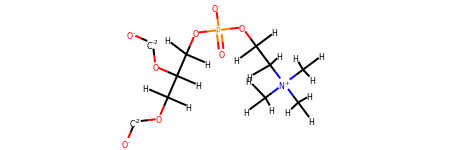

In [5]:
lig = prolif.Ligand.from_pytraj(traj[":294"])
lig

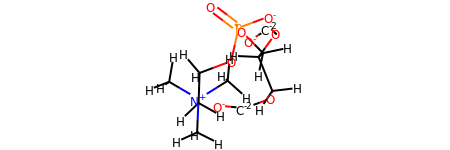

In [6]:
frame = next(iter(lig))
frame

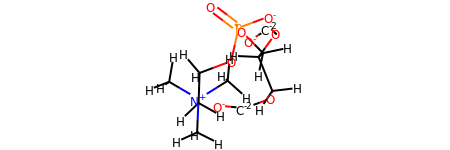

In [7]:
r = next(iter(frame))
r

In [34]:
prot = prolif.Protein.from_pytraj(traj["!(:WAT,PA,PC,OL,K\+,Cl\-)"], reference=lig, cutoff=25)

Detecting residues within 25 Å of the reference molecule in frame 0
centroid (ctd) = [84.88216247558594, 35.167925643920896, 26.561857318878175]
closest to ctd (cst) = [85.85326385498047, 34.7745361328125, 26.749479293823242]
farthest from cst (fct) = [81.73482513427734, 34.275516510009766, 20.86566162109375]
farthest from fct (ftf) = [85.48957824707031, 36.25408172607422, 31.494956970214844]
Detected 5 residues inside the binding pocket


In [32]:
prot.__repr__()

'<prolif.protein.Protein: 20 frame(s), 5 residues, 4866 atoms, 4929 bonds, 64 rings at 0x7fc3a800cf48>'

# Topology tests

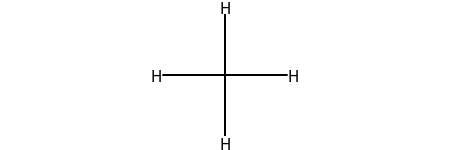

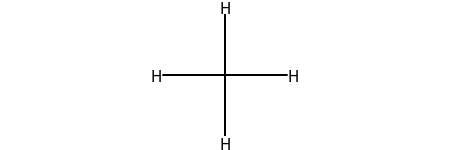

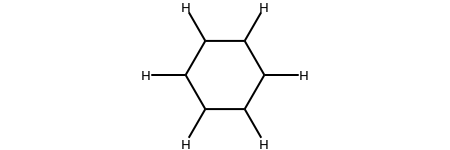

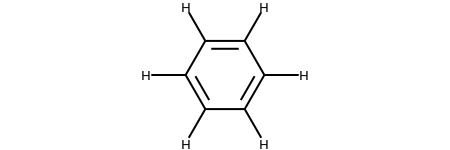

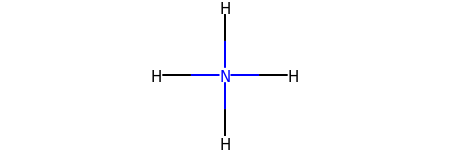

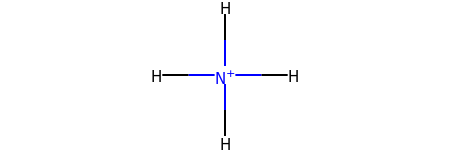

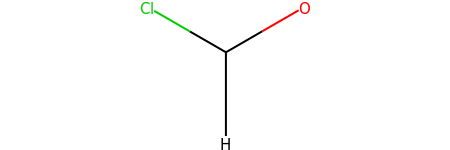

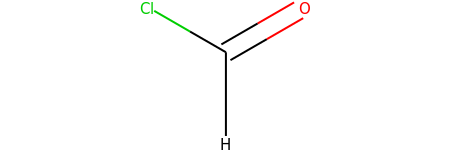

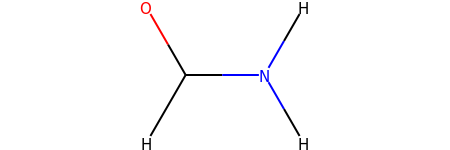

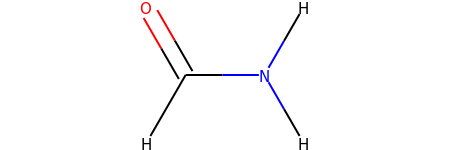

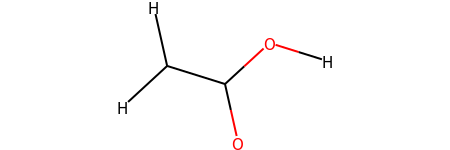

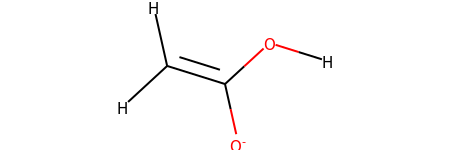

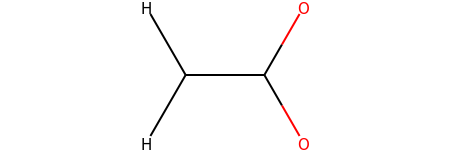

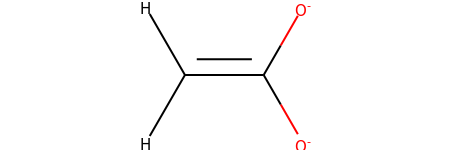

RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 161 in file /opt/conda/conda-bld/rdkit_1561471048963/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [12:50:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 161 in file /opt/conda/conda-bld/rdkit_1561471048963/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [12:50:22] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 161 in file /opt/conda/conda-bld/rdkit_1561471048963/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_expl

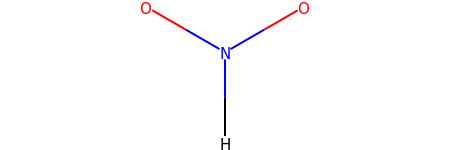

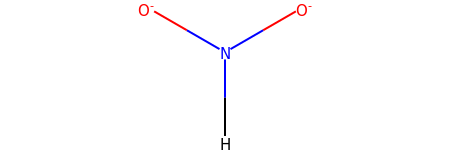

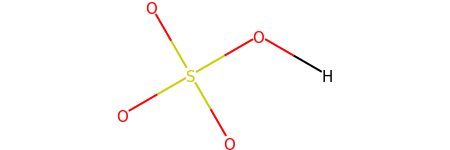

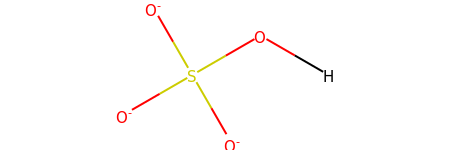

In [100]:
tests = [
    "[C](-[H])(-[H])(-[H])-[H]",
    "[C]1(-[H])-[C](-[H])-[C](-[H])-[C](-[H])-[C](-[H])-[C]1(-[H])",
    "[N](-[H])(-[H])(-[H])-[H]",
    "[Cl]-[C](-[H])-[O]",
    "[H]-[C](-[O])-[N](-[H])-[H]",
    "[H]-[C](-[H])-[C](-[O][H])-[O]",
    "[H]-[C](-[H])-[C](-[O])-[O]",
    "[O]-[N](-[O])-[H]",
    "[O]-[S](-[O])(-[O])-[O]-[H]"
]
for s in tests:
    mol = Chem.RWMol(Chem.MolFromSmiles(s, sanitize=False))
    display(mol)
    prolif.utils.update_bonds_and_charges(mol)
    display(mol)